# Introduction

Competition: Time Series  

https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/  

About Practice Problem: Time Series  
Time Series forecasting & modeling plays an important role in data analysis. Time series analysis is a specialized branch of statistics used extensively in fields such as Econometrics & Operation Research.  

Time Series is being widely used in analytics & data science. This is specifically designed time series problem for you and challenge is to forecast traffic.  

Rules:  
1. One person cannot participate with more than one user accounts.
2. This is proprietary dataset, you can only use for this hackathon (Analytics Vidhya Datahack Platform) not for any other reuse
3. You are free to use any tool and machine you have rightful access to.
4. You can use any programming language or statistical software.
5. You are free to use solution checker as many times as you want.

In [236]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.model_selection import RandomizedSearchCV as rscv
import warnings
from itertools import permutations

warnings.filterwarnings('ignore')

# pd.options.display.max_columns = None
# pd.options.display.max_rows = 56

filepath = 'D:/code/Data/time_series_datahack/'

data = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')
sample = pd.read_csv(f'{filepath}sample_submission.csv')

# Data Exploration

In [237]:
display(data)
display(test)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00
...,...,...
5107,23395,26-04-2015 19:00
5108,23396,26-04-2015 20:00
5109,23397,26-04-2015 21:00
5110,23398,26-04-2015 22:00


Oh. There's only 1 input and 1 output.  

Well, that may not seem like a lot, but think of all the FEATURE GENERATION you can do!!!
1. Year, Month, Day, Hour
2. Traffic in a preceding window of time (like traffic in the past x minutes)
3. Holidays!
4. More!!!

Make sure to train the FINAL model on ALL the data, after all parameters have been selected!!!

In [238]:
data.describe()

#Why the crap doesn't it describe the Datetime? Maybe because they're all unique.

,ID,Count
count,18288.000000,18288.000000
mean,9143.500000,138.958115
std,5279.435197,153.467461
min,0.000000,2.000000
25%,4571.750000,22.000000
50%,9143.500000,84.000000
75%,13715.250000,210.000000
max,18287.000000,1244.000000


# Data Cleaning

In [239]:
display(data.isnull().sum())

ID          0
Datetime    0
Count       0
dtype: int64

Nice! No missing data. Easy Mode!        

We should check if there's any gaps in the dates, or if it's a continuous run.  
The dates are spread out at hour intervals. Looks like 2 years of data. Dope!!

# Feature Generation

Let's do some feature generation:  
1. Year
2. Month
3. Day
4. Hour
5. Day of the week
6. Day of the year
7. Week of the year

In [240]:
# First, convert from string to the datetime object in Pandas. This makes it easier to find the year, month, etc...
data['Datetime'] = pd.to_datetime(data['Datetime'], format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test['Datetime'], format = '%d-%m-%Y %H:%M')

# Now, some features

#Here's a function to generate the desired features
def domain_features(df):
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour
    df['Dayofweek'] = df['Datetime'].dt.dayofweek
    df['Dayofyear'] = df['Datetime'].dt.dayofyear
    df['Week'] = df['Datetime'].dt.week
    
domain_features(data)
domain_features(test)

#Ideally, we will also generate some range features. Things like lag (Count in a previous window of time). But I need to research how to do this for the test data as well
# I guess you'd predict row 1, then generate lag, then predict row 2, then generate more lag, etc.

In [241]:
display(data)

,ID,Datetime,Count,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,238,34
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,238,34
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,238,34
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,238,34
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,238,34
...,...,...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,268,39
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,268,39
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,268,39
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,268,39


# Data Plotting

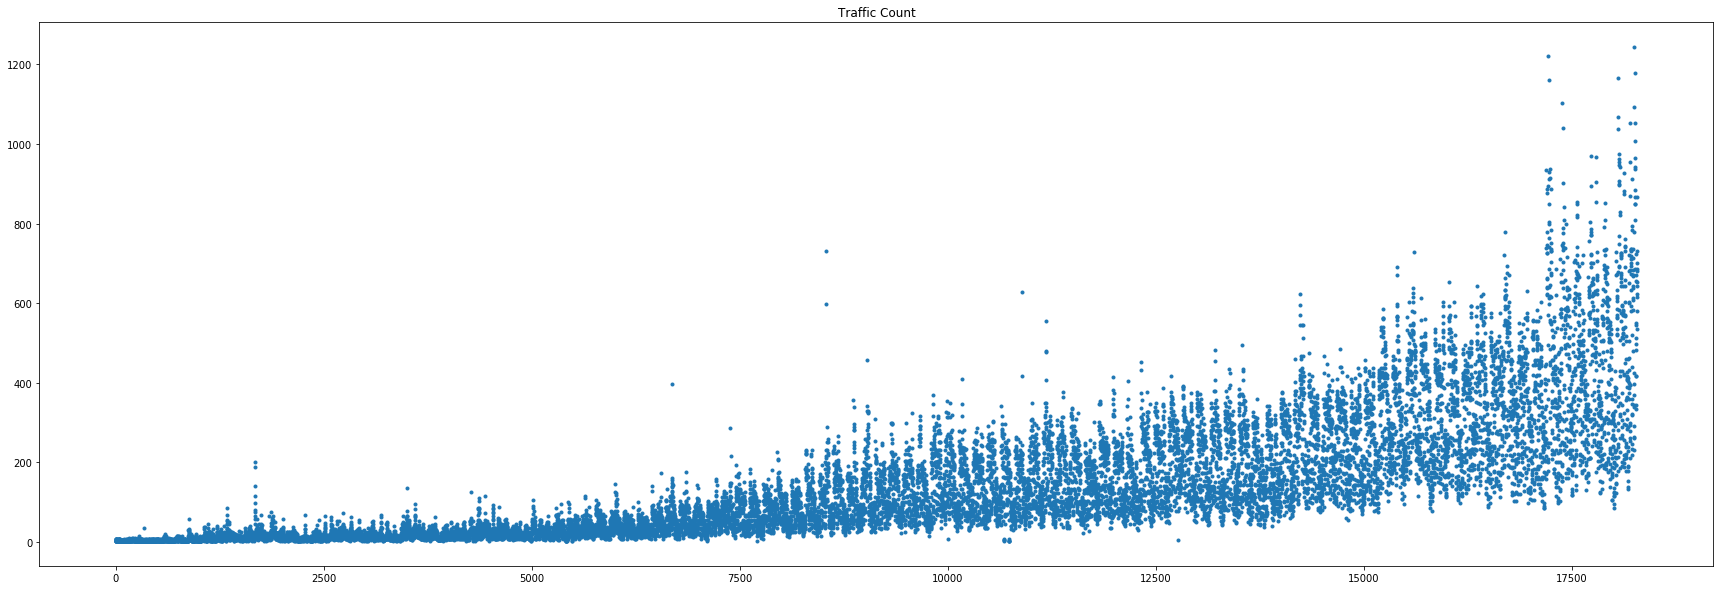

In [242]:
plt.figure(figsize = (30, 10))
data.Count.plot(style = '.')
plt.title(f'Traffic Count')
plt.autoscale()
plt.show()

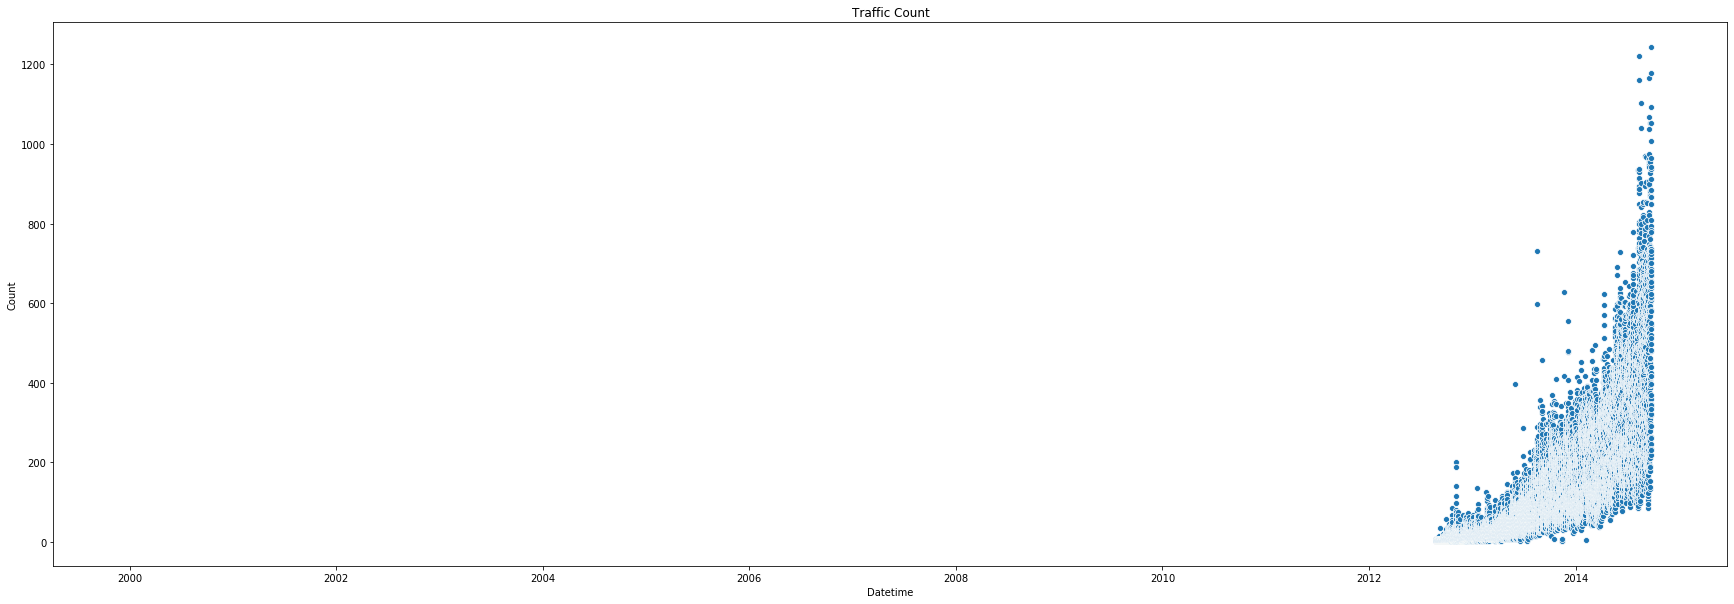

In [243]:
# Why is this one so scooted over??

plt.figure(figsize = (30, 10))
sns.scatterplot(x = data.Datetime, y = data.Count)
plt.title(f'Traffic Count')
plt.autoscale()
plt.show()

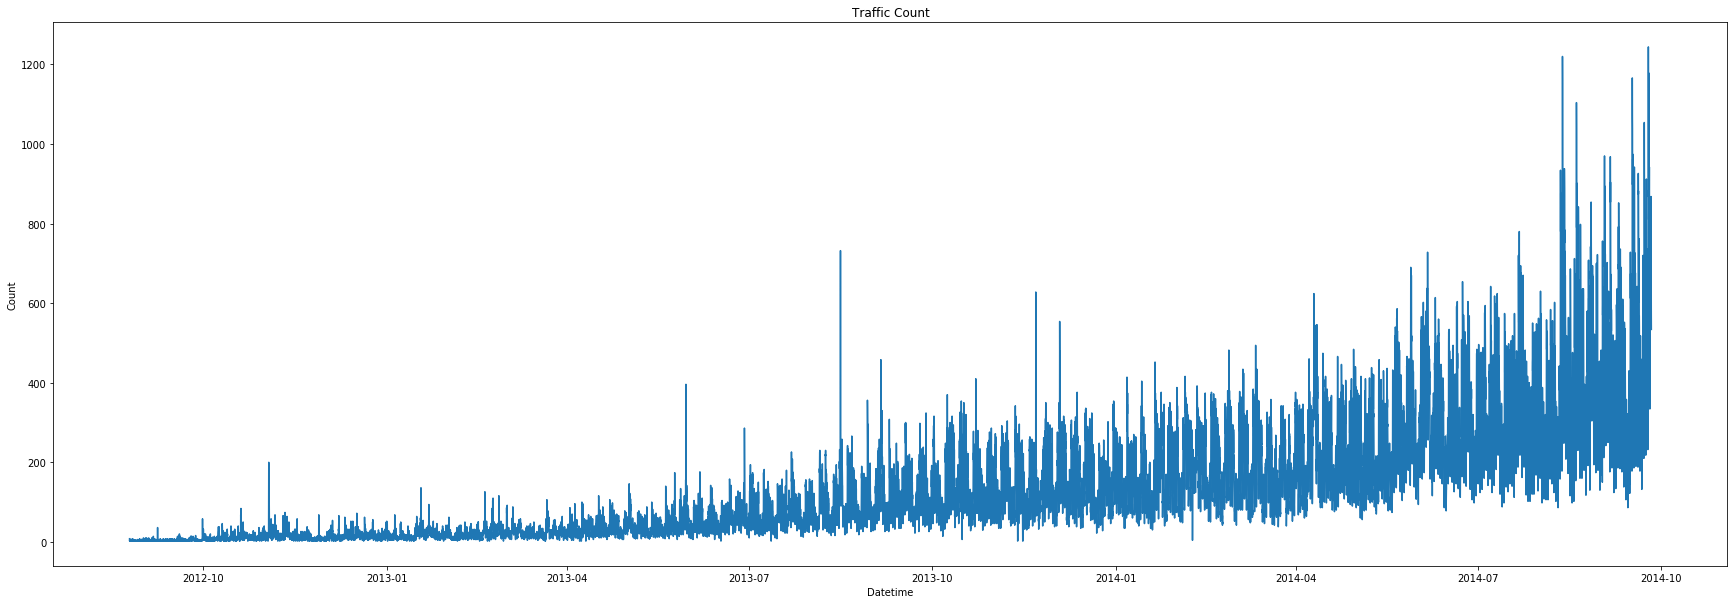

In [244]:
# Eh, don't like this one

plt.figure(figsize = (30, 10))
sns.lineplot(x = data.Datetime, y = data.Count)
plt.title(f'Traffic Count')
plt.autoscale()
plt.show()

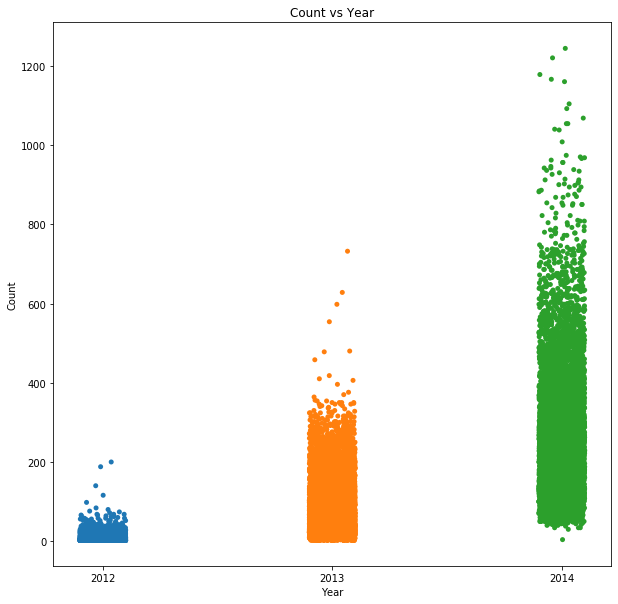

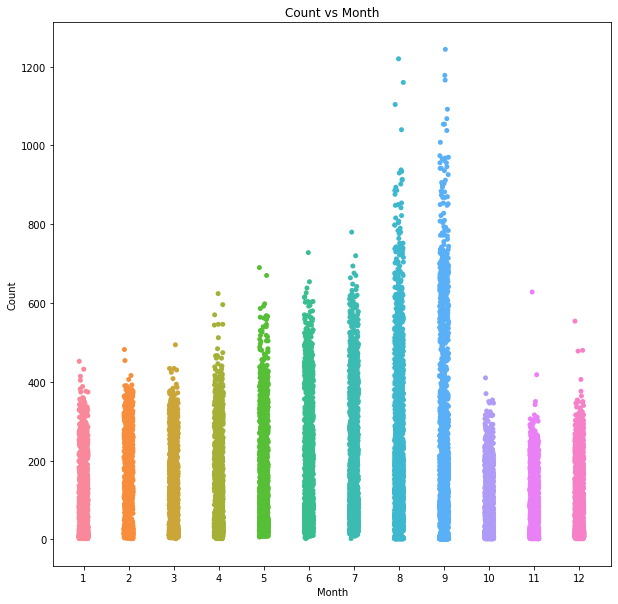

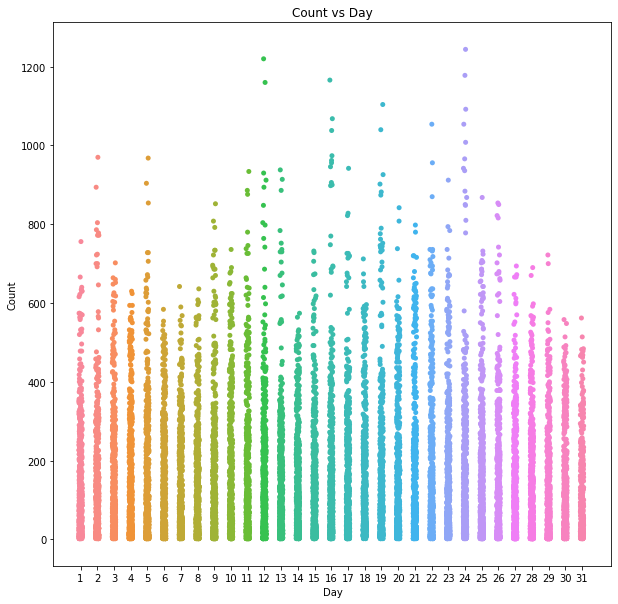

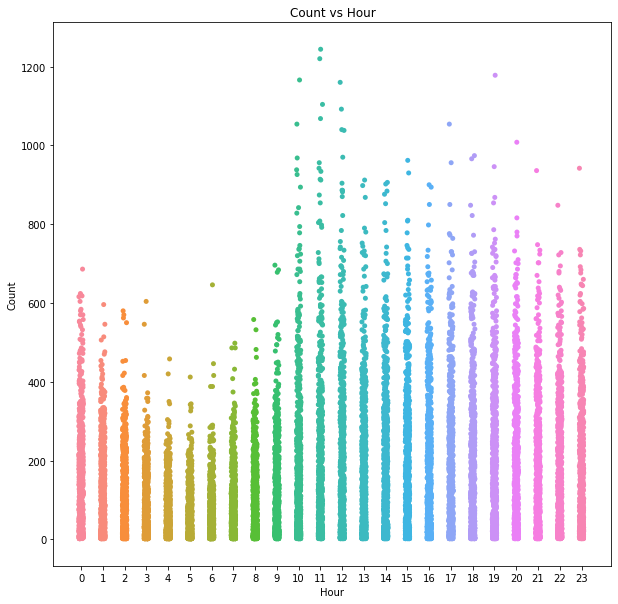

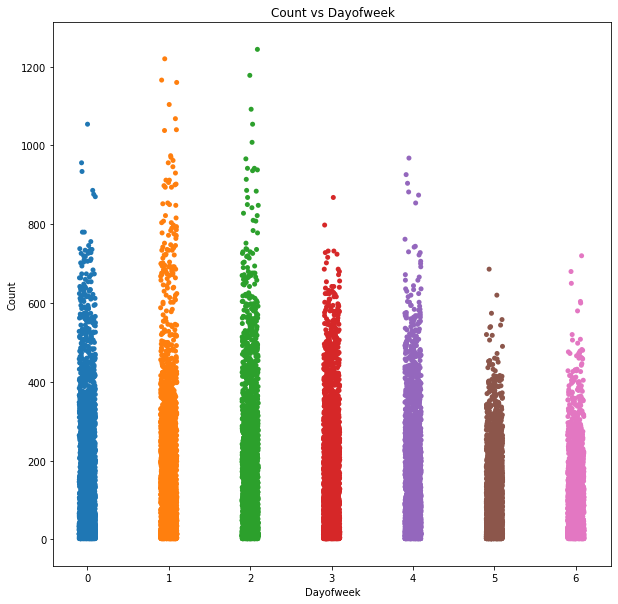

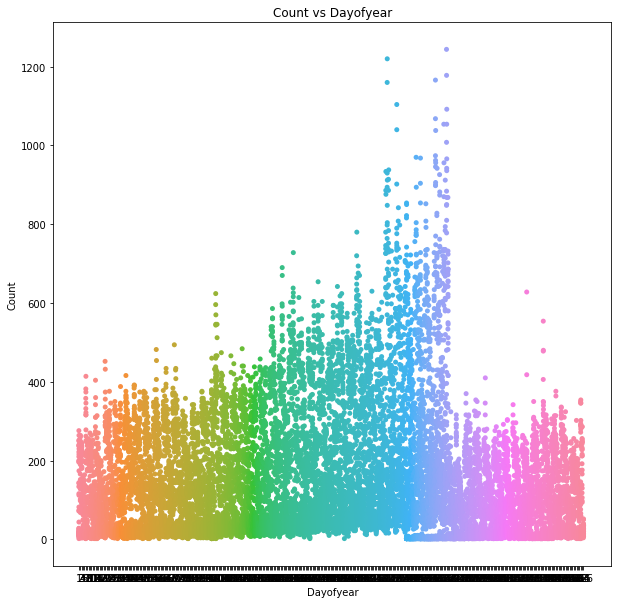

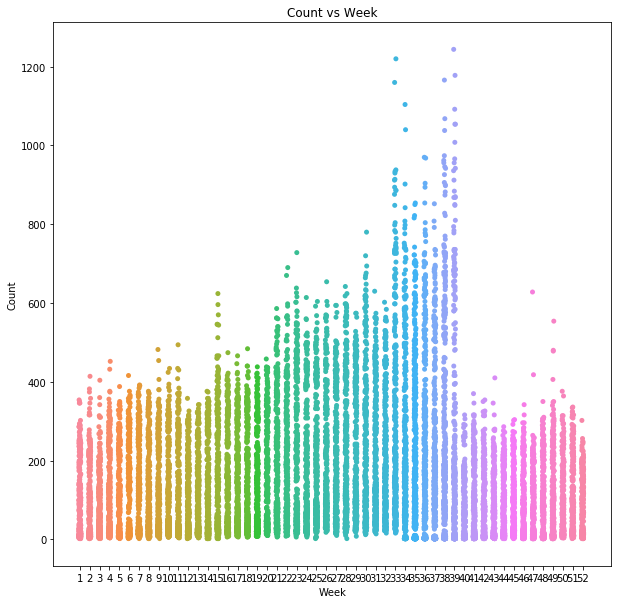

In [245]:
for feature in data.loc[:, 'Year':]:

    plt.figure(figsize = (10, 10))
    graph = sns.stripplot(x = feature, y = 'Count', hue = None, data = data)
    plt.title(f'Count vs {feature}')
    graph.autoscale()
    plt.show()

# Correlation

In [246]:
corr = data.corr()
display(corr)

,ID,Count,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week
ID,1.000000,0.780628,0.914277,-1.252140e-01,3.519011e-03,1.311196e-03,-3.412345e-03,-1.278150e-01,-1.192923e-01
Count,0.780628,1.000000,0.674422,-1.580793e-03,-1.823101e-03,2.019169e-01,-1.667922e-01,-3.815246e-03,4.778247e-03
Year,0.914277,0.674422,1.000000,-5.149179e-01,-3.531297e-02,0.000000e+00,-2.646015e-03,-5.186236e-01,-5.014813e-01
Month,-0.125214,-0.001581,-0.514918,1.000000e+00,9.631257e-03,-5.438272e-18,-1.035835e-03,9.964115e-01,9.743542e-01
Day,0.003519,-0.001823,-0.035313,9.631257e-03,1.000000e+00,6.809503e-18,3.855013e-03,9.387427e-02,7.049420e-02
Hour,0.001311,0.201917,0.000000,-5.438272e-18,6.809503e-18,1.000000e+00,-9.817597e-20,-2.583756e-20,-6.059024e-18
Dayofweek,-0.003412,-0.166792,-0.002646,-1.035835e-03,3.855013e-03,-9.817597e-20,1.000000e+00,-7.164747e-04,-1.639304e-03
Dayofyear,-0.127815,-0.003815,-0.518624,9.964115e-01,9.387427e-02,-2.583756e-20,-7.164747e-04,1.000000e+00,9.760286e-01
Week,-0.119292,0.004778,-0.501481,9.743542e-01,7.049420e-02,-6.059024e-18,-1.639304e-03,9.760286e-01,1.000000e+00


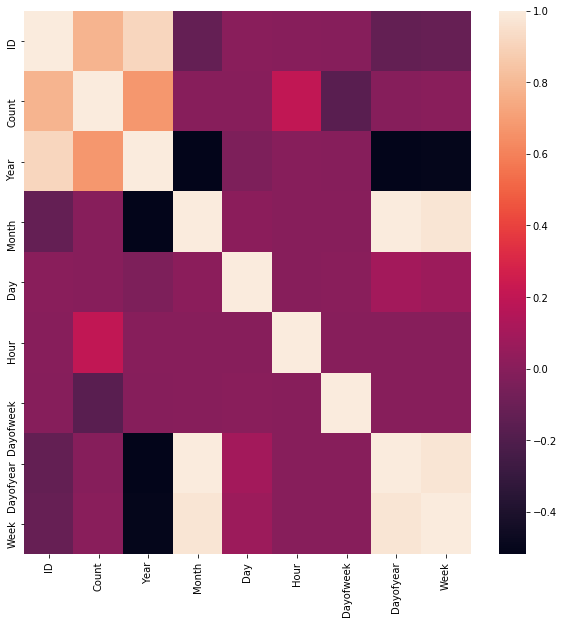

In [247]:
plt.figure(figsize = (10, 10))
sns.heatmap(corr)
plt.show()

<Figure size 720x720 with 0 Axes>

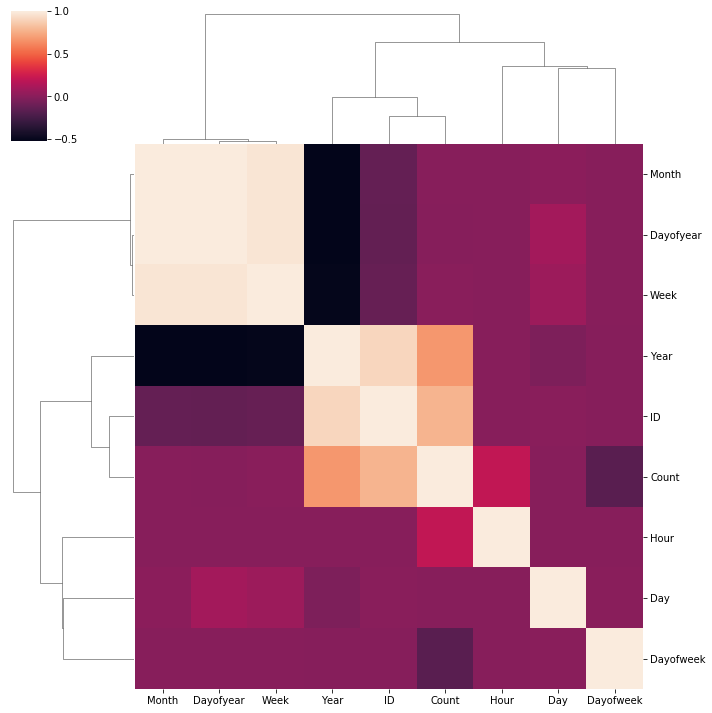

In [248]:
plt.figure(figsize = (10, 10))
sns.clustermap(corr)
plt.show()

# Model Training 1

Let's just dump everything into LightGBM and see what happens!!!  

Don't judge me, I'm lazy 😁

In [249]:
# Train Valid Split, I'll do k-fold later
# It's going to be important to keep leakage in mind, since this data is time based.
# Note, we don't need to split test data, as the competition has furnished us with test data.
# Why does it get so bad when I split the validation off from the end? Shouldn't that be good?

train, valid = train_test_split(data, shuffle = True, test_size = .2)

X_train = train.loc[:, 'Year':]
y_train = train.loc[:, 'Count']

X_valid = valid.loc[:, 'Year':]
y_valid = valid.loc[:, 'Count']

display(X_train)
display(X_valid)

,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week
7542,2013,7,5,6,4,186,27
6238,2013,5,11,22,5,131,19
2906,2012,12,24,2,0,359,52
4571,2013,3,3,11,6,62,9
1675,2012,11,2,19,4,307,44
...,...,...,...,...,...,...,...
13223,2014,2,26,23,2,57,9
5180,2013,3,28,20,3,87,13
5456,2013,4,9,8,1,99,15
402,2012,9,10,18,0,254,37


,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week
6883,2013,6,7,19,4,158,23
7991,2013,7,23,23,1,204,30
28,2012,8,26,4,6,239,34
2023,2012,11,17,7,5,322,46
9108,2013,9,8,12,6,251,36
...,...,...,...,...,...,...,...
9949,2013,10,13,13,6,286,41
12490,2014,1,27,10,0,27,5
10619,2013,11,10,11,6,314,45
15065,2014,5,14,17,2,134,20


In [250]:
model = lgb.LGBMRegressor(num_iterations = 5000)

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for the dump model is {error}')

[1]	valid_0's l2: 18191.9
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 15120.1
[3]	valid_0's l2: 12627.4
[4]	valid_0's l2: 10616.2
[5]	valid_0's l2: 8970.71
[6]	valid_0's l2: 7623.9
[7]	valid_0's l2: 6537.12
[8]	valid_0's l2: 5632.25
[9]	valid_0's l2: 4912.61
[10]	valid_0's l2: 4323.03
[11]	valid_0's l2: 3835.94
[12]	valid_0's l2: 3425.03
[13]	valid_0's l2: 3085.62
[14]	valid_0's l2: 2813.23
[15]	valid_0's l2: 2583.56
[16]	valid_0's l2: 2399.05
[17]	valid_0's l2: 2245.31
[18]	valid_0's l2: 2114.77
[19]	valid_0's l2: 2007.29
[20]	valid_0's l2: 1913.74
[21]	valid_0's l2: 1827.68
[22]	valid_0's l2: 1758.91
[23]	valid_0's l2: 1701.76
[24]	valid_0's l2: 1651.16
[25]	valid_0's l2: 1606.47
[26]	valid_0's l2: 1569.55
[27]	valid_0's l2: 1533.07
[28]	valid_0's l2: 1500.2
[29]	valid_0's l2: 1473.77
[30]	valid_0's l2: 1443.92
[31]	valid_0's l2: 1417.8
[32]	valid_0's l2: 1394.34
[33]	valid_0's l2: 1374.41
[34]	valid_0's l2: 1357.08
[35]	valid_0's l2: 1338.25
[36]	

'RMSE for the dump model is 27.614319786678145'

In [251]:
# Is this actually an acceptable way to calculate percent error? Better check that later.

mean = data.Count.mean()
percent_error = error / mean * 100

display(f'RMSE for the dump model is {error:.2f}')
display(f'Percent Error for the dump model is {percent_error:.2f}%')

'RMSE for the dump model is 27.61'

'Percent Error for the dump model is 19.87%'

Well, not terrible for a basic dump, but we could do a whole lot better I'm sure!!! About 21%

But, let's see how we're doing so far. Let's retrain on the whole data, and do a sample submission. Note that retraining on all the data means no early stopping rounds.

In [252]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = lgb.LGBMRegressor(num_iterations = 2000)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit1.csv',index=False, header =1)

Nice! Improved on leaderboard. Up to 416 place (score of 225.7233529740)

# Feature Importance

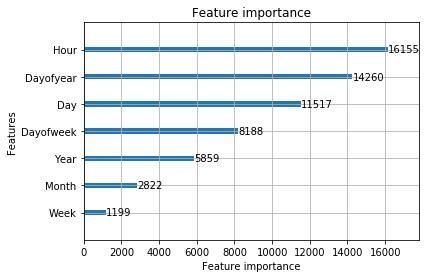

In [253]:
lgb.plot_importance(model)
plt.show()

# LightGBM Random Search

In [271]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

param_test = {
                'num_leaves': range(2, 10), 
                'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
                'n_estimators' : range(100, 5000, 100),
#                'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model = lgb.LGBMRegressor(silent=True, n_jobs=3, verbose = False)



rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 100,
            n_jobs = 2
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   21.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  3.6min finished


Best score reached: -87.57504089628529 with params: {'num_leaves': 4, 'n_estimators': 4400, 'learning_rate': 0.04} 


Let's keep track of some results as we tinker.

I believe this uses cross validation to score the random models.

Best score reached: -87.87970852411067 with params: {'num_leaves': 8, 'n_estimators': 400, 'learning_rate': 0.09} 
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   18.3s finished


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  3.6min finished
Best score reached: -87.57504089628529 with params: {'num_leaves': 4, 'n_estimators': 4400, 'learning_rate': 0.04}

In [272]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = lgb.LGBMRegressor(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit2.csv',index=False, header =1)

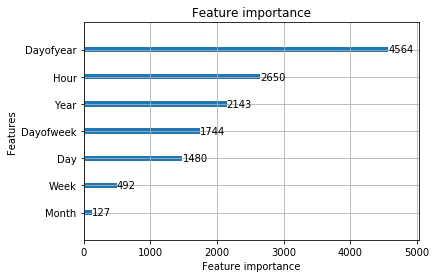

In [273]:
lgb.plot_importance(model)
plt.show()

# XGBoost Random Search

Let's compare LightGBM to XGBoost

In [ ]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

param_test = {
                'num_leaves': range(2, 10), 
                'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
                'n_estimators' : range(100, 5000, 100),
#                'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model = xgb.XGBRegressor(silent=True, n_jobs=3, verbose = False)



rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 100,
            n_jobs = 2
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  6.5min


Let's keep track of some results as we tinker.

I believe this uses cross validation to score the random models.

[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  2.2min finished
Best score reached: -89.66735403690507 with params: {'num_leaves': 8, 'n_estimators': 2700, 'learning_rate': 0.07}





In [ ]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = xgb.XGBRegressor(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit3.csv',index=False, header =1)

In [ ]:
xgb.plot_importance(model)
plt.show()

# Feature Generation 2

In [257]:
# Let's generate some lag features.

# data['lag_1'] = data['Count'].shift(1)
# data['lag_2'] = data['Count'].shift(2)
# data['lag_3'] = data['Count'].shift(3)
# data['lag_4'] = data['Count'].shift(4)
# data['lag_5'] = data['Count'].shift(5)
# data['lag_6'] = data['Count'].shift(6)
# data['lag_7'] = data['Count'].shift(7)


# test['lag_1'] = test['Count'].shift(1)
# test['lag_2'] = test['Count'].shift(2)
# test['lag_3'] = test['Count'].shift(3)
# test['lag_4'] = test['Count'].shift(4)
# test['lag_5'] = test['Count'].shift(5)
# test['lag_6'] = test['Count'].shift(6)
# test['lag_7'] = test['Count'].shift(7)

display(data)

,ID,Datetime,Count,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,238,34
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,238,34
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,238,34
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,238,34
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,238,34
...,...,...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,268,39
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,268,39
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,268,39
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,268,39


# Cross Validation

This time, don't split the data. Use built in k-fold. We'll try 5 and 10 folds.

In [267]:
# We have to make a LightGBM dataset for this to work

X_data = data.loc[:, 'Year':'Dayofweek']
y_data = data.loc[:, 'Count']

lgbdata = lgb.Dataset(X_data, y_data)

In [268]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_iterations' : 5000
}



model = lgb.cv(params, lgbdata, early_stopping_rounds=30, stratified = False)

display(model)


# valid_pred = model.predict(X_valid)
# error = np.sqrt(mse(valid_pred, y_valid))



# print('')

# display(f'RMSE for the dump model 2 is {error}')



{'l1-mean': [111.99652296349741,
  106.90037574781005,
  102.08531426021497,
  97.53066612874893,
  93.23132053931604,
  89.14879366852767,
  85.29622262980952,
  81.66046263226502,
  78.22207552744905,
  74.98588506760191,
  71.91210280694247,
  69.01364931914505,
  66.272080808636,
  63.67026263853809,
  61.22494580277703,
  58.93181875655357,
  56.77605478082662,
  54.7371577674776,
  52.8217207058017,
  51.0181149254319,
  49.32778228398089,
  47.7394493495992,
  46.26397264092208,
  44.87323239515445,
  43.561839054341995,
  42.32552258277112,
  41.179653364487045,
  40.09923338523583,
  39.08904869705309,
  38.14001783104189,
  37.23888551713495,
  36.41164010934627,
  35.62919496428996,
  34.910098802094545,
  34.248051558915066,
  33.61843228838412,
  33.019242262761416,
  32.479726223886026,
  31.970839118021775,
  31.484244497039434,
  31.026787778194052,
  30.600796934378486,
  30.211383579695216,
  29.843243215104383,
  29.485441826294874,
  29.150430403770912,
  28.8339869

Ok, I'm confused. What is CV? What is happening here? What are these results???  

What I was hoping was that I could train the model, with early stopping, and it would automatically slice the data into folds and train 5 times and average the models...

No idea what it's doing now.